# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)
np.set_printoptions(precision=10)
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})

# Load Data

In [2]:
def reloadData():
    
    global clean_data, X, Y, X_train, Y_train, X_test, Y_test
    
    clean_data = pd.read_pickle('dataset/Automobile-processed.pkl.bz2', compression='bz2')

    X = clean_data.drop(columns=['price'])
    Y = clean_data.price
    
    X_train = pd.read_pickle('dataset/Automobile-processed-X_train.pkl.bz2', compression='bz2')
    Y_train = pd.read_pickle('dataset/Automobile-processed-Y_train.pkl.bz2', compression='bz2')
    X_test  = pd.read_pickle('dataset/Automobile-processed-X_test.pkl.bz2', compression='bz2')
    Y_test  = pd.read_pickle('dataset/Automobile-processed-Y_test.pkl.bz2', compression='bz2')

In [3]:
reloadData();

train_LinearRegression = False
train_Ridge            = False
train_KNN              = False
train_MLP              = False
train_RandomForest     = False

# Auxiliar Functions

In [4]:
from sklearn.metrics import mean_squared_error,r2_score, \
                            explained_variance_score, \
                            max_error,mean_absolute_error
                            


def plotError(pred_data, actual_data):
    
    plt.rcParams['figure.figsize']=(7,4);
    
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('[Predicted VS. Real] + [Relative Error]')

    x = np.linspace(start=1, stop=len(actual_data), num=len(actual_data));
    
    axs[0].scatter(x, pred_data);
    axs[0].scatter(x, actual_data);
    axs[1].stem(x, abs(pred_data - actual_data)/actual_data, linefmt='grey', markerfmt='D', bottom=0);
    
    plt.grid(True);
    plt.ylim((0,1));
    plt.show();


def getModelScores(y,pred):
    print("Test R2 Score:", r2_score(y,pred));
    print("Test MSE:", mean_squared_error(y,pred));
    print("Test MAE:", mean_absolute_error(y,pred));
    print("Test Max Error:", max_error(y,pred));
    print("Test Explained Variance:", explained_variance_score(y,pred));

    
def getModelPredictionScores(model, x, y, plots=True):
    pred = model.predict(x);
    if plots:
        plotError(pred, y);
    getModelScores(y,pred)

    
def trainAndGetPredictionScores(model, xtrain, ytrain, xtest, ytest, plots=True):
    model.fit(xtrain, ytrain)
    getModelPredictionScores(model, xtest, ytest, plots)

    
def trainAndEvalModelWithKFold(modelito, myX, myY, myK):
    kfold = KFold(n_splits=myK,shuffle=True,random_state=42)
    total_score = 0
    
    # For each fold, re-fits the model (overwriting the previous one) with the
    # current train partition, and validates with the current test partition
    for train_indices, test_indices in kfold.split(myX.values):
        
        myX_train = myX.iloc[train_indices]
        myX_test = myX.iloc[test_indices]
        myY_train = myY.iloc[train_indices]
        myY_test = myY.iloc[test_indices]
        
        modelito.fit(myX_train, myY_train);

        pred = modelito.predict(myX_test);
        R2score = r2_score(myY_test, pred);
        total_score += R2score / myK;
        
        plotError(pred, myY_test);
        print("R2 Score: " + str(R2score));
        print("---------------------------------------------------------")
        
    print("=========================================================")
    print("   CrossVal Mean R2 Score: " + str(total_score))        
    print("=========================================================")

    
def plotCoefs(coefs):
    plt.rcParams['figure.figsize']=(20,30)

    norm_w = coefs;

    numerical_cols = ['symboling', 'normalized_losses', 'wheel_base', 'length', 'width','height', 'curb_weight', 'engine_size', 'compression_ratio','horsepower', 'city_mpg', 'highway_mpg'];
    makes          = ['make_alfa_romero','make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge','make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda','make_mercedes_benz', 'make_mercury', 'make_mitsubishi','make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche','make_saab', 'make_subaru', 'make_toyota', 'make_volkswagen','make_volvo'];
    aspiration     = ['aspiration_turbo'];
    body_style     = ['body_style_convertible', 'body_style_hardtop','body_style_hatchback','body_style_sedan', 'body_style_wagon'];
    drive_wheels   = ['drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd'];
    engine_type    = ['engine_type_dohc', 'engine_type_dohcv', 'engine_type_l','engine_type_ohc','engine_type_ohcf', 'engine_type_ohcv','engine_type_rotor'];
    fuel_system    = ['fuel_system_carburation', 'fuel_system_injection'];

    n_numerical    = len(numerical_cols);
    n_makes        = len(makes);
    n_aspiration   = len(aspiration);
    n_body_style   = len(body_style);
    n_drive_wheels = len(drive_wheels);
    n_engine_type  = len(engine_type);
    n_fuel_system  = len(fuel_system);
    
    fig, axs = plt.subplots(6, sharex=True)
    fig.suptitle('Coefeicientes de variables categoricas')
    
    axs[0].barh(X.columns[0:n_numerical],norm_w[0:n_numerical]);
    axs[1].barh(X.columns[n_numerical:n_numerical+n_makes],norm_w[n_numerical:n_numerical+n_makes]);
    axs[2].barh(X.columns[n_numerical+n_makes+n_aspiration:n_numerical+n_makes+n_aspiration+n_body_style],norm_w[n_numerical+n_makes+n_aspiration:n_numerical+n_makes+n_aspiration+n_body_style]);
    axs[3].barh(X.columns[n_numerical+n_makes+n_aspiration+n_body_style:n_numerical+n_makes+n_aspiration+n_body_style+n_drive_wheels],norm_w[n_numerical+n_makes+n_aspiration+n_body_style:n_numerical+n_makes+n_aspiration+n_body_style+n_drive_wheels]);
    axs[4].barh(X.columns[n_numerical+n_makes+n_aspiration+n_body_style+n_drive_wheels:],norm_w[n_numerical+n_makes+n_aspiration+n_body_style+n_drive_wheels:]);
    axs[5].barh(X.columns[n_numerical+n_makes:n_numerical+n_makes+n_aspiration],norm_w[n_numerical+n_makes:n_numerical+n_makes+n_aspiration]);

# Linear Regression

In [5]:
reloadData();

Using pre-computed best params: {'n_features_to_select': [48]}
Best Model:

  - Best Params: {'n_features_to_select': 48} 

  - R2 CV Score: 0.8625129429778529


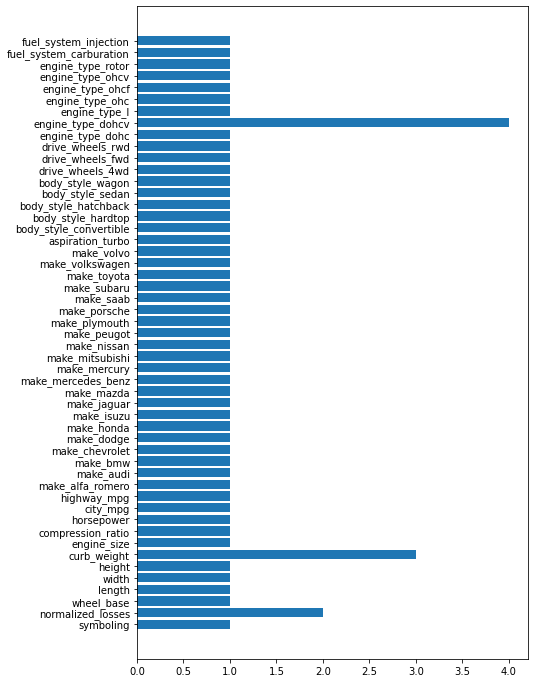

In [6]:
if train_LinearRegression:    
    paramgrid = {'n_features_to_select': list(range(1, 1 + len(X_train.columns.values)))}
    train_LinearRegression = False

else:
    paramgrid = {'n_features_to_select': [48]}
    print("Using pre-computed best params:", paramgrid)
    


gscv = GridSearchCV(estimator= RFE(LinearRegression(n_jobs=-1, copy_X=True)),
                    param_grid= paramgrid,
                    scoring= 'r2',
                    n_jobs= -1,
                    cv=KFold(n_splits=5,shuffle=True,random_state=42),
                    verbose = 0);

gscv.fit(X_train, Y_train);

print("Best Model:\n")
print("  - Best Params:", gscv.best_params_, "\n");
print("  - R2 CV Score:", gscv.best_score_);

plt.rcParams['figure.figsize']=(7,12);
plt.barh(X_train.columns.values, gscv.best_estimator_.ranking_);

Omitimos las 3 columnas que parecen ser poco utiles al estimador. En cross_val Score con datos de entrenamiento, en comparacion a no eliminarlas, aumentamos el R2 de 0.80 a 0.86. Por lo tanto, nos quedamos con la version que elimina estas 3 features.

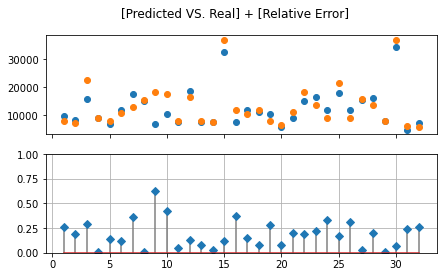

R2 Score: 0.7909564954938614
---------------------------------------------------------


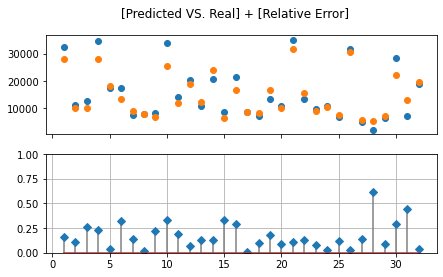

R2 Score: 0.8318033278589415
---------------------------------------------------------


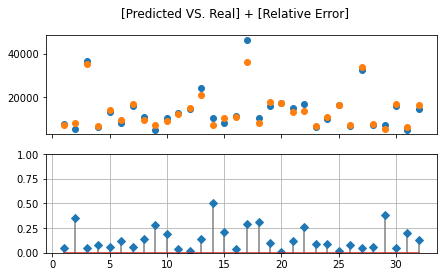

R2 Score: 0.905683596360951
---------------------------------------------------------


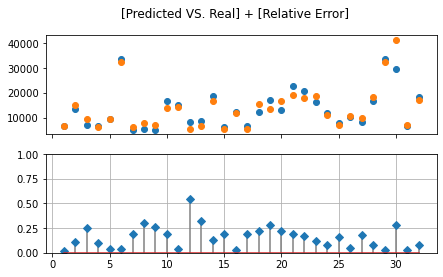

R2 Score: 0.8825590956439792
---------------------------------------------------------


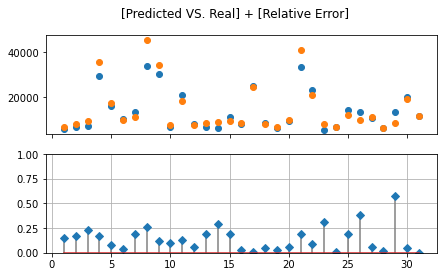

R2 Score: 0.9015621995315305
---------------------------------------------------------
   CrossVal Mean R2 Score: 0.8625129429778526


In [7]:
linearRegressor = gscv.best_estimator_

trainAndEvalModelWithKFold(linearRegressor, X_train, Y_train, 5)

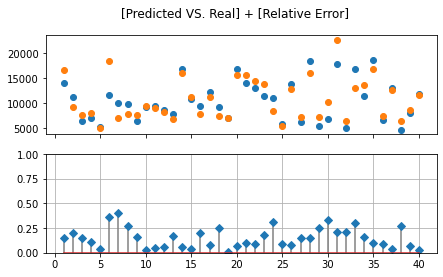

Test R2 Score: 0.7396111546623978
Test MSE: 4364820.748061767
Test MAE: 1620.037059465986
Test Max Error: 6638.940154800424
Test Explained Variance: 0.7418111179927893


In [8]:
# Test partition prediction
getModelPredictionScores(linearRegressor, X_test, Y_test, plots=True)

# Ridge

In [9]:
reloadData();

In [10]:
if train_Ridge:    
    
    train_Ridge = False
    # lambdas = 10**np.arange(-6,7,0.99)                   # result = 0.87
    # lambdas = np.linspace(start=-10,stop=10,num=100);   # result = 0.7
    # lambdas = np.linspace(start=-1,stop=1,num=10);     # result = 0.77
    lambdas = np.linspace(start=0.6,stop=0.8,num=100);   # result = 0.6079079079079079
    
else:
    lambdas = [0.7575757575757576, 0.696969696969697]
    print("Using pre-computed best params:", lambdas)

    
ridge = RidgeCV(alphas=lambdas,
                scoring='r2',
                cv=KFold(n_splits=5,shuffle=True,random_state=42))

ridge.fit(X_train, Y_train);
print("Best Model:\n")
print("  - Best lambda:", ridge.alpha_, "\n");
print("  - R2 CV Score:", ridge.best_score_);


new_X_train = X_train.drop(columns=['normalized_losses', 'curb_weight', 'engine_type_dohcv'])

ridge.fit(new_X_train, Y_train);
print("\n\nBest Model (without LR removed features):\n")
print("  - Best lambda:", ridge.alpha_, "\n");
print("  - R2 CV Score:", ridge.best_score_);

Using pre-computed best params: [0.7575757575757576, 0.696969696969697]
Best Model:

  - Best lambda: 0.7575757575757576 

  - R2 CV Score: 0.8937070948315584


Best Model (without LR removed features):

  - Best lambda: 0.696969696969697 

  - R2 CV Score: 0.8956747169297354


Como el R2 del que elimina las features es mayor, nos quedamos con ese.

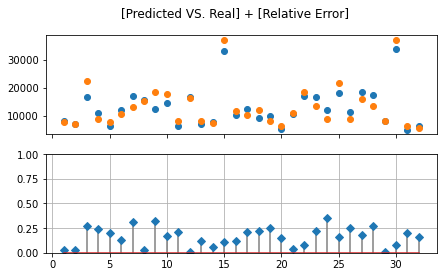

R2 Score: 0.8846702279649781
---------------------------------------------------------


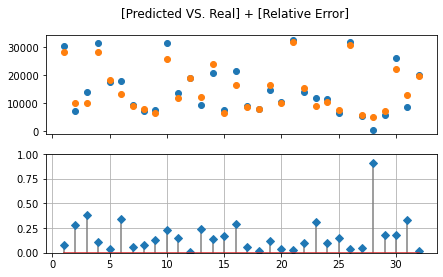

R2 Score: 0.886701701868995
---------------------------------------------------------


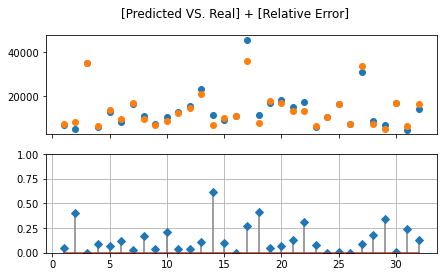

R2 Score: 0.9060449324485171
---------------------------------------------------------


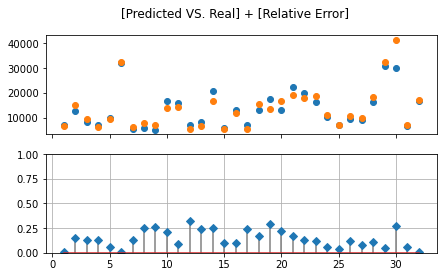

R2 Score: 0.8909012431673553
---------------------------------------------------------


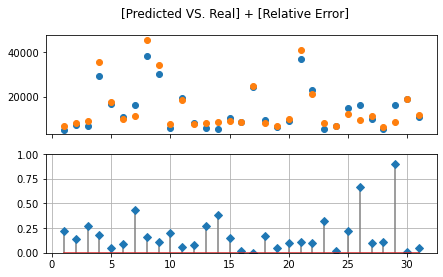

R2 Score: 0.9100554791988313
---------------------------------------------------------
   CrossVal Mean R2 Score: 0.8956747169297353


In [11]:
X_train = new_X_train
X_test = X_test.drop(columns=['normalized_losses', 'curb_weight', 'engine_type_dohcv'])

trainAndEvalModelWithKFold(ridge, X_train, Y_train, 5)

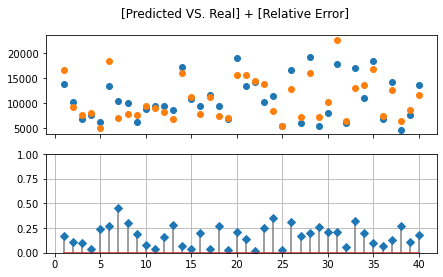

Test R2 Score: 0.7004780740656745
Test MSE: 5020796.935915327
Test MAE: 1838.771306381248
Test Max Error: 4894.912584091217
Test Explained Variance: 0.7016551441024413


In [12]:
getModelPredictionScores(ridge, X_test, Y_test, plots=True)

# KNN

In [13]:
reloadData();
train_KNN              = False

In [14]:
if train_KNN:
    
    train_KNN              = False
    knn_params = {'n_neighbors' : [n for n in range(1,10)], 
                  'weights' : ['uniform', 'distance'],
                  'metric' : ['euclidean', 'manhattan', 'chebyshev']}
    
else:
    knn_params = {'n_neighbors' : [3], 
                  'weights' : ['distance'],
                  'metric' : ['manhattan']}
    
    print("Using pre-computed best params:", knn_params)
    

knn = GridSearchCV(estimator= KNeighborsRegressor(n_jobs=-1),
                   param_grid= knn_params,
                   scoring= 'r2',
                   n_jobs= -1,
                   cv=KFold(n_splits=5,shuffle=True,random_state=42),
                   verbose = 1);

knn.fit(X_train,Y_train);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    2.4s finished


In [15]:
print(knn.best_estimator_)
print(knn.best_params_)

best_knn = knn.best_estimator_;

KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=3,
                    weights='distance')
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


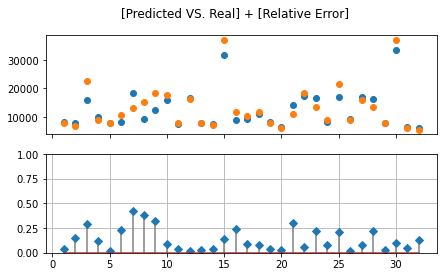

R2 Score: 0.8617611898485356
---------------------------------------------------------


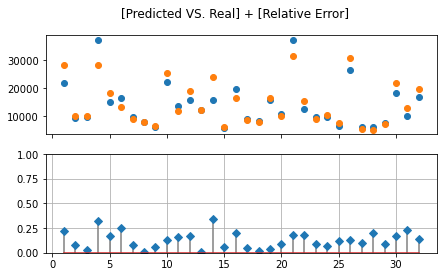

R2 Score: 0.8269217210018507
---------------------------------------------------------


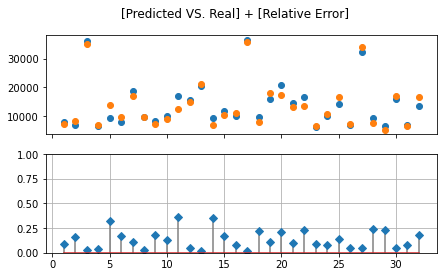

R2 Score: 0.94319872113837
---------------------------------------------------------


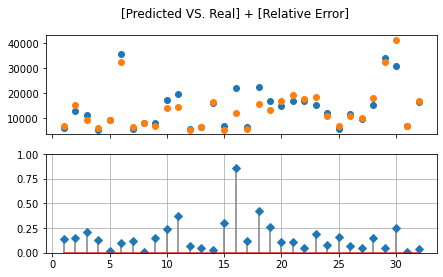

R2 Score: 0.8341247137614677
---------------------------------------------------------


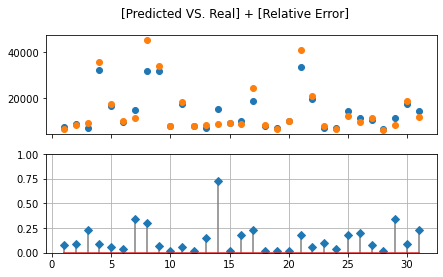

R2 Score: 0.8885838938787227
---------------------------------------------------------
   CrossVal Mean R2 Score: 0.8709180479257893


In [16]:
trainAndEvalModelWithKFold(best_knn, X_train, Y_train, 5)

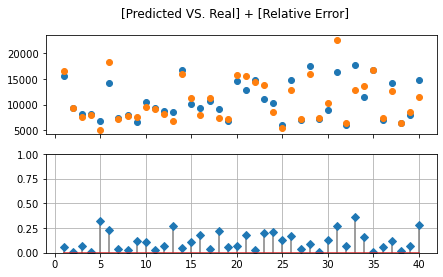

Test R2 Score: 0.7890922379250007
Test MSE: 3535384.0700767273
Test MAE: 1318.5330007258744
Test Max Error: 6186.7901744114315
Test Explained Variance: 0.7890939144601911


In [17]:
getModelPredictionScores(best_knn, X_test, Y_test, plots=True)

# MLP Regressor

In [18]:
reloadData();
train_MLP              = False  # Con 16 threads tarda >24h

In [19]:
if train_MLP:
    
    train_MLP              = False
    
    sizes = [[i for i in range(1,25)]]
    sizes = sizes + [[i,i] for i in range(1,25)]
    sizes = sizes + [[i,i,i] for i in range(1,25)]

    param_grid = {'alpha' : (0.00001, 0.0001, 0.001, 0.01),
                  'hidden_layer_sizes': sizes, 
                  'activation': ('identity', 'relu', 'logistic', 'tanh'),
                  'learning_rate_init':[0.005,0.05,0.001,0.1]
                 }
else:
    param_grid = {'alpha' : [0.001],
                  'hidden_layer_sizes': [[24, 24]], 
                  'activation': ['relu'],
                  'learning_rate_init' : [0.001]
                 }
    print("Using pre-computed best params:", param_grid)

    
model_nnet = GridSearchCV(estimator= MLPRegressor(max_iter=100000,
                                                  solver='adam',
                                                  learning_rate='adaptive',
                                                  random_state=42),
                          
                          scoring= 'r2',
                          param_grid= param_grid,
                          n_jobs=-1,
                          cv=KFold(n_splits=5,shuffle=True,random_state=42),
                          verbose = 1);

model_nnet.fit(X_train,Y_train);

Using pre-computed best params: {'alpha': [0.001], 'hidden_layer_sizes': [[24, 24]], 'activation': ['relu'], 'learning_rate_init': [0.001]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


In [20]:
print(model_nnet.best_estimator_)
print(model_nnet.best_params_)
best_model_nnet = model_nnet.best_estimator_;

MLPRegressor(alpha=0.001, hidden_layer_sizes=[24, 24], learning_rate='adaptive',
             max_iter=100000, random_state=42)
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': [24, 24], 'learning_rate_init': 0.001}


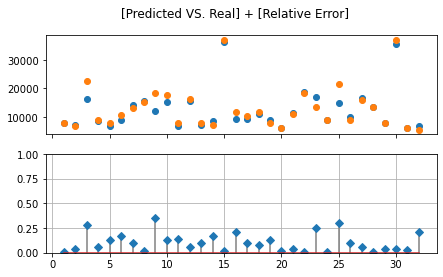

R2 Score: 0.9113713277349507
---------------------------------------------------------


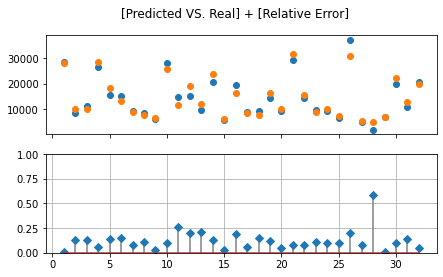

R2 Score: 0.9250214542153711
---------------------------------------------------------


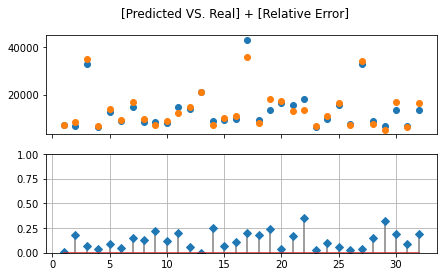

R2 Score: 0.9237238227193909
---------------------------------------------------------


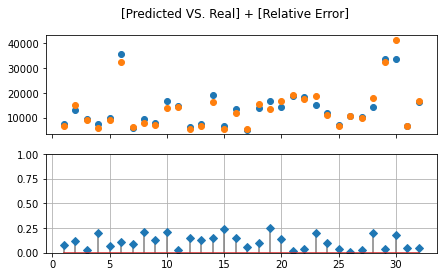

R2 Score: 0.9336764109447286
---------------------------------------------------------


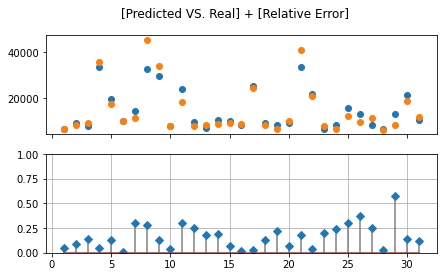

R2 Score: 0.8921830233282817
---------------------------------------------------------
   CrossVal Mean R2 Score: 0.9171952077885446


In [21]:
trainAndEvalModelWithKFold(best_model_nnet, X_train, Y_train, 5)

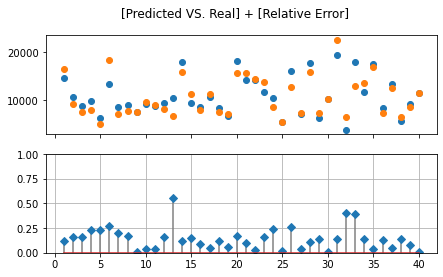

Test R2 Score: 0.7786831478903247
Test MSE: 3709868.549597693
Test MAE: 1483.5024510411888
Test Max Error: 5091.686306828378
Test Explained Variance: 0.7830540128578598


In [22]:
getModelPredictionScores(best_model_nnet, X_test, Y_test, plots=True)

# Random Forest

In [23]:
reloadData();
train_RandomForest     = False

In [24]:
if train_RandomForest:
    
    train_RandomForest     = False    
    
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]


    param_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

else:    
    param_grid = {'n_estimators': [200],
                  'min_samples_split': [5],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt'],
                  'max_depth': [40],
                  'bootstrap': [False]}
    
    print("Using pre-computed best params:", param_grid)
    

random_forest = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = param_grid,
                                   n_iter = 2500,
                                   cv = KFold(n_splits=5,
                                              shuffle=True,
                                              random_state=42),
                                   verbose=1,
                                   random_state=42,
                                   n_jobs = -1)

random_forest.fit(X_train, Y_train)

Using pre-computed best params: {'n_estimators': [200], 'min_samples_split': [5], 'min_samples_leaf': [1], 'max_features': ['sqrt'], 'max_depth': [40], 'bootstrap': [False]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Edgar\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=2500. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_iter=2500, n_jobs=-1,
                   param_distributions={'bootstrap': [False], 'max_depth': [40],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [5],
                                        'n_estimators': [200]},
                   random_state=42, verbose=1)

In [25]:
print(random_forest.best_estimator_)
print(random_forest.best_params_)
best_random_forest = random_forest.best_estimator_;

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      min_samples_split=5, n_estimators=200)
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


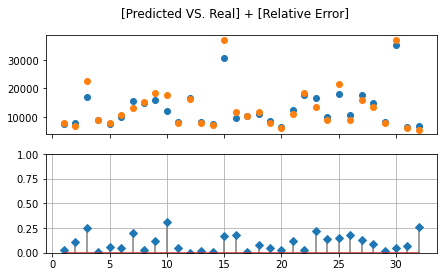

R2 Score: 0.9155308214269059
---------------------------------------------------------


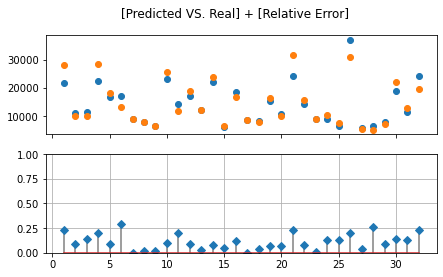

R2 Score: 0.8702844594523628
---------------------------------------------------------


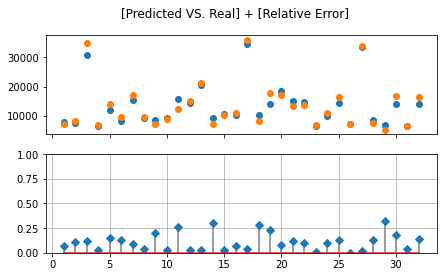

R2 Score: 0.9517027443305842
---------------------------------------------------------


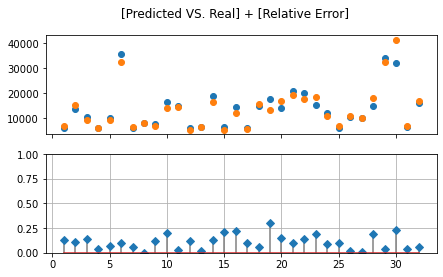

R2 Score: 0.9154262828895192
---------------------------------------------------------


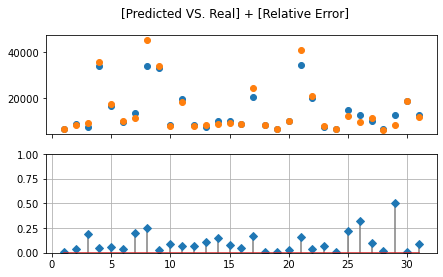

R2 Score: 0.9281030456002232
---------------------------------------------------------
   CrossVal Mean R2 Score: 0.9162094707399191


In [26]:
trainAndEvalModelWithKFold(best_random_forest, X_train, Y_train, 5)

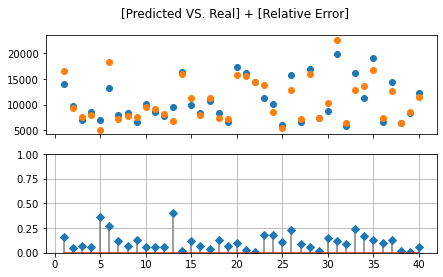

Test R2 Score: 0.8425885416840262
Test MSE: 2638641.4454482906
Test MAE: 1223.591729166667
Test Max Error: 5060.619999999995
Test Explained Variance: 0.8426628197902079


In [27]:
getModelPredictionScores(best_random_forest, X_test, Y_test, plots=True)

# Load/Save Models

In [28]:
# Save to Pickle
import pickle
version = 9
#pickle.dump( linearRegressor,    open( "models/linearRegressor_v" + str(version) + ".pkl", "wb" ) )
#pickle.dump( ridge,              open( "models/ridge_v" + str(version) + ".pkl", "wb" ) )
#pickle.dump( lasso,              open( "models/lasso_v" + str(version) + ".pkl", "wb" ) )
#pickle.dump( best_knn,           open( "models/best_knn_v" + str(version) + ".pkl", "wb" ) )
#pickle.dump( best_model_nnet,    open( "models/model_nnet_v" + str(version) + ".pkl", "wb" ) )
#pickle.dump( best_random_forest, open( "models/random_forest_v" + str(version) + ".pkl", "wb" ) )

In [29]:
# Load from Pickle
import pickle
version = 9
linearRegressor = pickle.load( open( "models/linearRegressor_v" + str(version) + ".pkl", "rb" ) )
ridge =           pickle.load( open( "models/ridge_v" + str(version) + ".pkl", "rb" ) )
lasso =           pickle.load( open( "models/lasso_v" + str(version) + ".pkl", "rb" ) )
best_knn =        pickle.load( open( "models/best_knn_v" + str(version) + ".pkl", "rb" ) )
model_nnet_best =      pickle.load(open( "models/model_nnet_v" + str(version) + ".pkl", "rb" ))